<b><font size="5">Gradient Boosting Model(XGBoost)</font></b>

First we start by importing our liberaries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score

Then we load and inspect our Data

In [23]:
df = pd.read_csv("cleaned_retail_demand_data.csv")
display(df.info())
display(df.describe().T)
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97757 entries, 0 to 97756
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Product_id        97757 non-null  int64 
 1   Product_Code      97757 non-null  object
 2   Warehouse         97757 non-null  object
 3   Product_Category  97757 non-null  object
 4   Date              97757 non-null  object
 5   Order_Demand      97757 non-null  int64 
 6   Open              97757 non-null  int64 
 7   Promo             97757 non-null  int64 
 8   StateHoliday      97757 non-null  object
 9   SchoolHoliday     97757 non-null  int64 
 10  Petrol_price      97757 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 8.2+ MB


None

,count,mean,std,min,25%,50%,75%,max
Product_id,97757.0,960147.049654,54762.231320,768635.0,915459.0,963998.0,1008327.0,1048574.0
Order_Demand,97757.0,575.832718,874.112505,0.0,10.0,100.0,1000.0,4950.0
Open,97757.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Promo,97757.0,0.468662,0.499020,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,97757.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Petrol_price,97757.0,87.988922,4.907497,80.0,84.0,88.0,92.0,96.0


,Product_id,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
0,786967,Product_0551,Whse_S,Category_030,01/03/2016,3000,1,0,0,0,85
1,786856,Product_0556,Whse_S,Category_030,01/03/2016,1000,1,0,0,0,93
2,899538,Product_1844,Whse_A,Category_018,01/03/2016,7,1,0,0,0,95
3,786726,Product_0470,Whse_S,Category_005,01/03/2016,2000,1,0,0,0,80
4,899733,Product_0643,Whse_A,Category_028,01/03/2016,2,1,0,0,0,85


<b><font size="5">Feature Engineering</font></b>

Date shows the date of the last product count. We can change this to an attribute, to show the day, month, and year as numerical values

In [24]:
# Convert date to datetime - using the correct format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Changed format
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek

#Drop the old Date column
df.drop(columns="Date", inplace=True)

display(df.head())

,Product_id,Product_Code,Warehouse,Product_Category,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price,Day,Month,Year,DayOfWeek
0,786967,Product_0551,Whse_S,Category_030,3000,1,0,0,0,85,3,1,2016,6
1,786856,Product_0556,Whse_S,Category_030,1000,1,0,0,0,93,3,1,2016,6
2,899538,Product_1844,Whse_A,Category_018,7,1,0,0,0,95,3,1,2016,6
3,786726,Product_0470,Whse_S,Category_005,2000,1,0,0,0,80,3,1,2016,6
4,899733,Product_0643,Whse_A,Category_028,2,1,0,0,0,85,3,1,2016,6


We can also drop other columns that does not affect the ouput. The first three columns have the same value for all records, and StudentID is just an identifier

In [25]:
df.drop(columns=['Open', 'SchoolHoliday', 'Year', 'Product_id', 'StateHoliday'],inplace=True)
display(df.head())

,Product_Code,Warehouse,Product_Category,Order_Demand,Promo,Petrol_price,Day,Month,DayOfWeek
0,Product_0551,Whse_S,Category_030,3000,0,85,3,1,6
1,Product_0556,Whse_S,Category_030,1000,0,93,3,1,6
2,Product_1844,Whse_A,Category_018,7,0,95,3,1,6
3,Product_0470,Whse_S,Category_005,2000,0,80,3,1,6
4,Product_0643,Whse_A,Category_028,2,0,85,3,1,6


Now we can find our categorical, and numerical features

In [26]:
output_var = 'Order_Demand'
numeric_data = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_data if col != output_var]
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'Numeric Features    : {numeric_features}')
print(f'Categorical Features: {categorical_features}')

Numeric Features    : ['Promo', 'Petrol_price', 'Day', 'Month', 'DayOfWeek']
Categorical Features: ['Product_Code', 'Warehouse', 'Product_Category']


**Numerical Data Engineering**

Now we can visualize our Numerical Data

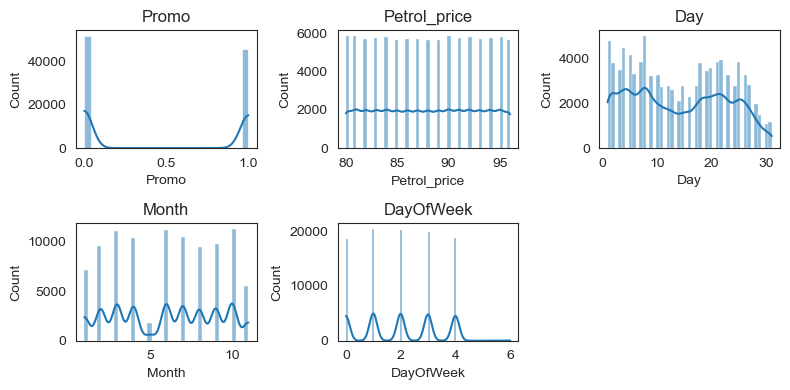

In [27]:
plt.figure(figsize=(8, 4))
for i, col in enumerate(df[numeric_features].columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

This data seems very seasonal. We can test for skewness using the skewness coefficient. We see that no skewness coefficient is over 1

In [28]:
for col in numeric_data:
    print(f'{col} = {df[col].skew()}')

Order_Demand = 1.9951737739610709
Promo = 0.12560049902297604
Petrol_price = -0.001982969899227081
Day = 0.09661816810257062
Month = -0.06153289890537462
DayOfWeek = 0.03097046298610477


Now we can generate box-plots of our features

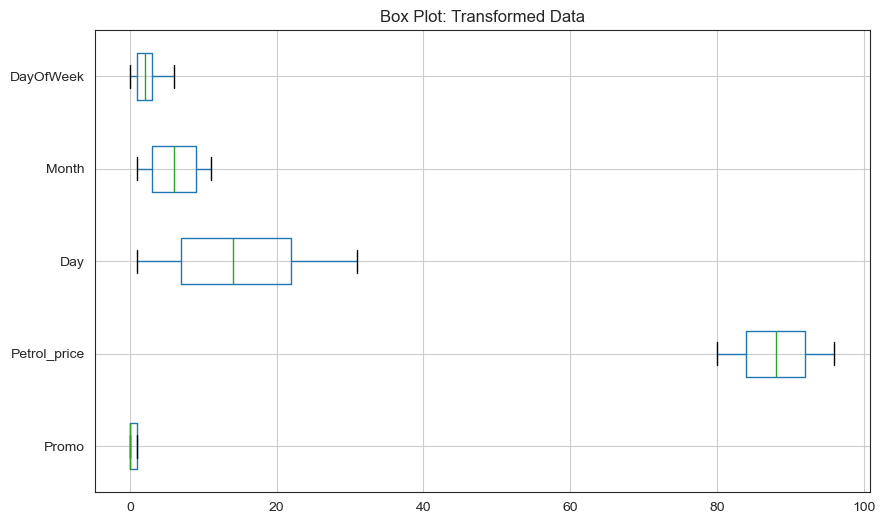

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Transformed Data')

We can apply slight scaling to all numeric data. We can use the minmax scaler to scale the values of all features to fit between 0 and 1 to fit with our promo values

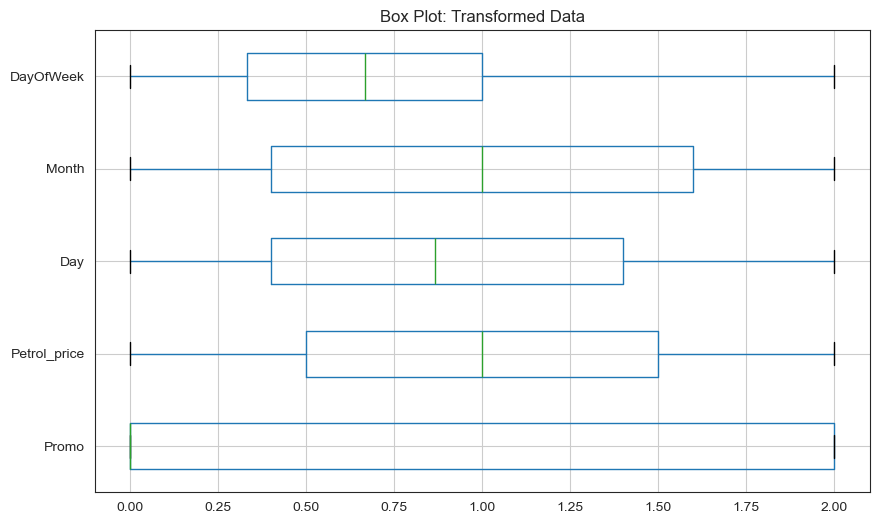

In [30]:
scaler = MinMaxScaler(feature_range=(0, 2))
scaler.fit(df[numeric_features])

df[numeric_features] = scaler.transform(df[numeric_features])

fig, ax = plt.subplots(figsize=(10, 6))
boxplot = df[numeric_features].boxplot(vert = 0, ax=ax)  
_ = ax.set_title(f'Box Plot: Transformed Data')

**Categorical Data Engineering**

In [31]:
print(f'Categorical Features: {categorical_features}')

Categorical Features: ['Product_Code', 'Warehouse', 'Product_Category']


We can encode values to our categorical data

In [32]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['Product_Code', 'Warehouse', 'Product_Category']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

View our correlation coefficients

In [33]:
def CorrPlot(df, dropDuplicates = True, figsize = (8, 6)):
    # df = df.corr()
    df = np.abs(df.corr())
    # Exclude duplicate correlations by masking upper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    # Set background color / chart style
    sns.set_style(style = 'white')
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=figsize)
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                    annot=True,
                    square=True,
                    linewidth=.5, cbar_kws={"shrink": .75}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)

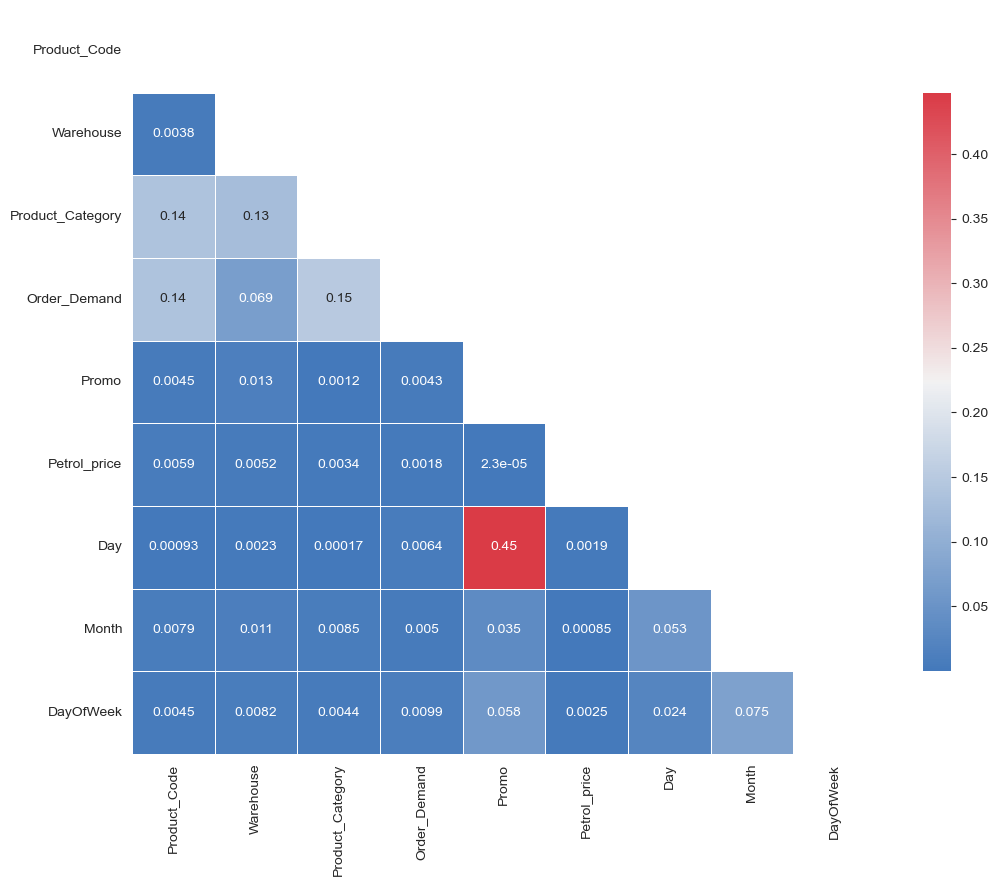

In [34]:
CorrPlot(df, figsize = (12, 10))

Extract features and define input and output variables

In [35]:
features = df.columns.drop(output_var).to_list()
X = df[features]
Y = df[output_var]
display(X, Y)

,Product_Code,Warehouse,Product_Category,Promo,Petrol_price,Day,Month,DayOfWeek
0,534,3,26,0.0,0.625,0.133333,0.0,2.000000
1,539,3,26,0.0,1.625,0.133333,0.0,2.000000
2,1734,0,15,0.0,1.875,0.133333,0.0,2.000000
3,455,3,2,0.0,0.000,0.133333,0.0,2.000000
4,619,0,24,0.0,0.625,0.133333,0.0,2.000000
...,...,...,...,...,...,...,...,...
97752,584,2,0,0.0,1.125,1.133333,2.0,1.333333
97753,601,2,0,0.0,0.125,1.133333,2.0,1.333333
97754,1166,0,16,0.0,1.625,1.133333,2.0,1.333333
97755,1401,2,16,0.0,0.125,1.133333,2.0,1.333333


0        3000
1        1000
2           7
3        2000
4           2
         ... 
97752       8
97753       1
97754    1800
97755     200
97756       2
Name: Order_Demand, Length: 97757, dtype: int64

Now we can split our data into testing and training sets

In [36]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

<b><font size="5">Machine Model Training</font></b>

**XGBoost**

In [37]:
model = XGBRegressor(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, Y_train)

C:\Users\marco\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:25:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mlogloss',
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

In [40]:
train_mae = np.round(mean_absolute_error(Y_train, Y_train_pred), 3)#The ,3 is just to 3 decimal places
train_mse = np.round(mean_squared_error(Y_train, Y_train_pred), 3)
train_rmse = np.round(np.sqrt(train_mse), 3)

print(f"Comparisons of Metrics - TRAINING DATA")
print(f"Training MAE - {train_mae}")
print(f"Training MSE - {train_mse}")
print(f"Training RMSE - {train_rmse}") 
print()

test_mae = np.round(mean_absolute_error(Y_test, Y_test_pred), 3)#The ,3 is just to 3 decimal places
test_mse = np.round(mean_squared_error(Y_test, Y_test_pred), 3)
test_rmse = np.round(np.sqrt(test_mse), 3)

print(f"Comparisons of Metrics - TESTING DATA")
print(f"Training MAE - {test_mae}")
print(f"Training MSE - {test_mse}")
print(f"Training RMSE - {test_rmse}") 

Comparisons of Metrics - TRAINING DATA
Training MAE - 381.21
Training MSE - 391637.025
Training RMSE - 625.809

Comparisons of Metrics - TESTING DATA
Training MAE - 413.976
Training MSE - 462012.06
Training RMSE - 679.715
